In [42]:
import networkx as nx
from pyvis.network import Network

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
import ipywidgets as widgets
from ipywidgets import interact, IntSlider

from src.city import *
from src.constants import *

## Plot different types of graphs

In [2]:

styles = {
    "type0": { # center to task start
        "color": "green",
        "label": "city center to task start",
        "linestyle": "dotted"
    }, 
    "type1": { # task end to center
        "color": "red",
        "label": "task end to city center",
        "linestyle": "dotted" 
    },
    "type2": { # between task
        "color": "blue",
        "label": "between tasks",
        "linestyle": "dashed" 
    },
    "type3": { # task start to task end
        "color": "black",
        "label": "task start to task end",
        "linestyle": "dashed" 
    }
}

def get_path_type(u: int, v: int, start_and_end_id: list[int], n_ids: int) -> str:
    """
        Returns the key of the style keyword args based on the from and to node ids
        Does not check whether the ids are in the correct range yet
    """
    assert len(start_and_end_id) == 2, "wrong number of start and end ids"
    assert u in (range(n_ids)) and v in (range(n_ids)), "u and v are not in the correct range"
    assert not u == v, "self edges not allowed"

    if u == start_and_end_id[0] and v not in start_and_end_id:
        return "type0"
    elif v == start_and_end_id[1] and u not in start_and_end_id:
        return "type1"
    elif v not in start_and_end_id and u not in start_and_end_id:
        return "type2"
        
    else:
        raise Exception("u and v are not in the correct range")
    

def plot_city_edges(city: City, E: list[Edge], ax: Axes, title: str):
    # get props
    task_start_positions = city.positions_start
    task_end_positions = city.positions_end
    n_tasks = city.n_tasks
    start_task_id = n_tasks 
    end_task_id = n_tasks + 1

    # Unzip start and end positions
    start_x, start_y = zip(*task_start_positions)
    end_x, end_y = zip(*task_end_positions)

    # add task nodes and center
    ax.scatter(start_x, start_y, s=50, color='k')
    ax.scatter(end_x, end_y, s=50, color='k', marker='X')
    ax.plot(*city.get_center(), "ks", markersize=10)

    # draw arrows between tasks 
    for e in E:
        u = int(e.from_vertex.name)
        v = int(e.to_vertex.name)
        path_type = get_path_type(u, v, [start_task_id, end_task_id], n_tasks +2)
        args = styles[path_type]

        ux, uy = task_end_positions[u]
        vx, vy = task_start_positions[v]
        dx = vx - ux
        dy = vy - uy
        ax.arrow(ux, uy, dx, dy, head_width=0.5, length_includes_head=True, **args)

    # draw arrows from task starts to task ends
    for n in range(n_tasks + 2):
        dx = end_x[n] - start_x[n]
        dy = end_y[n] - start_y[n]
        args = styles["type3"]
        ax.arrow(start_x[n], start_y[n], dx, dy, head_width=0.3, length_includes_head=True, **args)

    # set axis props
    ax.set_xlim(-5, city.width + 5)
    ax.set_ylim(-5, city.height + 5)
    ax.set_title(title)
    colors = [v["color"] for v in styles.values()]
    labels = [v["label"] for v in styles.values()]
    handles = [Line2D([], [], color=color, label=label)
               for color, label in zip(colors, labels)]
    ax.legend(handles=handles)
    ax.grid(True)
    

def visualize_paths(city: City, vsp_path: list[int] = None, title: str = "Paths"):
    """
    Visualizes every reachable path of the city

    @param city -- The City class to visualize.
    @param vsp_path --  The solution path of the SVSP instance. Will not show if none is provided.
    """
    # create edges if not existing
    if len(city.graph.vertices) == 0:
        city.create_graph()
    G = city.graph
    E = list(G.get_edges())

    # the solution path is a list of binary variable indicating the selected edges
    if vsp_path is not None:
        assert len(vsp_path) == len(E), "edge sizes do not match"
        E_vsp = [E[n] for n in range(len(E)) if vsp_path[n] == 1]
        
    # figure
    if vsp_path is not None:
        # Create a figure with two subplots arranged horizontally
        fig, (ax, ax_vsp) = plt.subplots(1, 2, figsize=(40, 15))
        plot_city_edges(city, E, ax, title="tasks")
        plot_city_edges(city, E_vsp, ax_vsp, title="solution")
    else:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(111)
        plot_city_edges(city, E, ax, title="tasks")

    # labels and axis props
    plt.gca().set_aspect('equal')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(title)
    
    # Show plot
    plt.show()


7


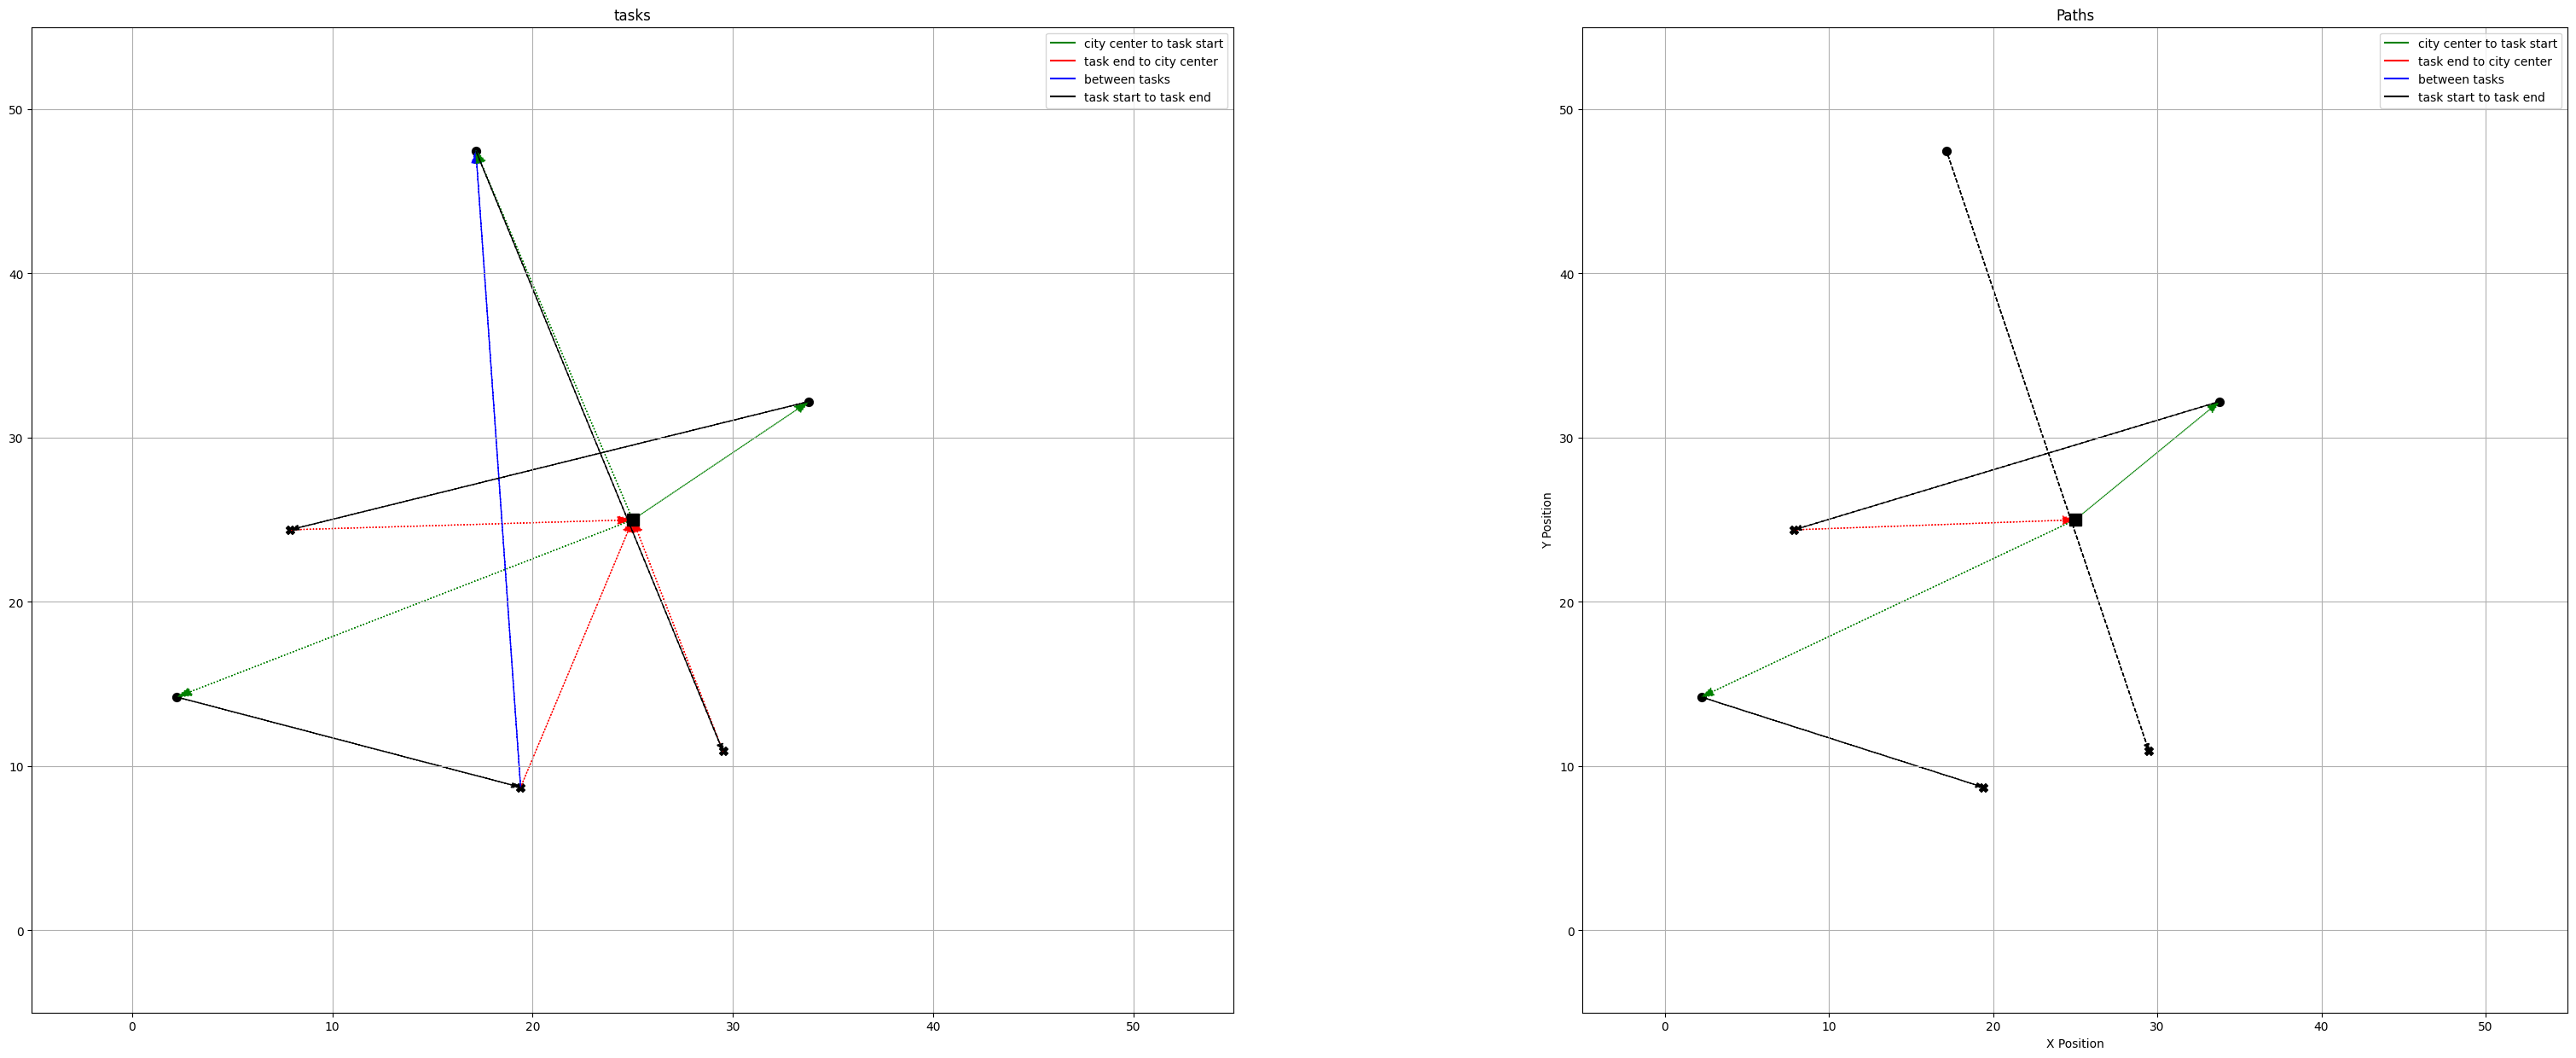

In [21]:
# plot all paths
np.random.seed(51)
n_tasks = 3
city = City(CITY_HEIGHT_MINUTES, CITY_WIDTH_MINUTES, N_DISTRICTS_X, N_DISTRICTS_Y, n_tasks, N_SCENARIOS)
city.create_graph()
N = len(city.graph.get_edges())
labels = np.random.randint(2, size=N)
visualize_paths(city, vsp_path=labels)

In [15]:
def visualize_tasks(city: City, 
                    show_heatmap: bool = False, 
                    vsp_path: list = None, 
                    show_reachable_paths: bool = False):
    """
    Plots every (task start -> task end) of the given city instance on the city map including the center

    Keyword arguments:
    @param city -- The City class to visualize.
    @param show_heatmap -- Plot the heatmap of intra-district delays on the city map, and
                    the heatmap of inter-district delays on a separate figure.
                    Also shows a draggable bar to show the city state corresponding 
                    to a specific time in a day.
    @param vsp_path --  The solution path of the SVSP instance. Will not show if none is provided.
    @param show_reachabele_paths -- Show the reachable paths of the city
    """
    task_start_positions = city.positions_start[:-2]
    task_end_positions = city.positions_end[:-2]
    n_tasks = city.n_tasks
    inter_scenario_delays = city.scenario_delays_inter

    # Unzip start and end positions
    start_x, start_y = zip(*task_start_positions)
    end_x, end_y = zip(*task_end_positions)
    
    # colors
    cm = plt.get_cmap('gist_rainbow')
    # fig, axes = plt.subplots(nrows=3, ncols=1)
    # ax = axes[0]
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111)
    colors = [cm(1.*i/(n_tasks)) for i in range(n_tasks)]
    ax.set_prop_cycle(color=colors)

    # add task nodes
    ax.scatter(start_x, start_y, s=30, color=colors)
    ax.scatter(end_x, end_y, s=30, color=colors, marker='X')

    # add center
    ax.plot(*city.get_center(), "ks", markersize=10)

    # draw arrows
    for start, end, color in zip(task_start_positions, task_end_positions, colors):
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        ax.arrow(start[0], start[1], dx, dy, color=color, head_width=0.3, length_includes_head=True)

    # labels and axis props
    ax.legend()
    ax.set_xlim(-5, city.width + 5)
    ax.set_ylim(-5, city.height + 5)
    plt.gca().set_aspect('equal')
    plt.title('Tasks')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    
    # Show plot
    plt.grid(True)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


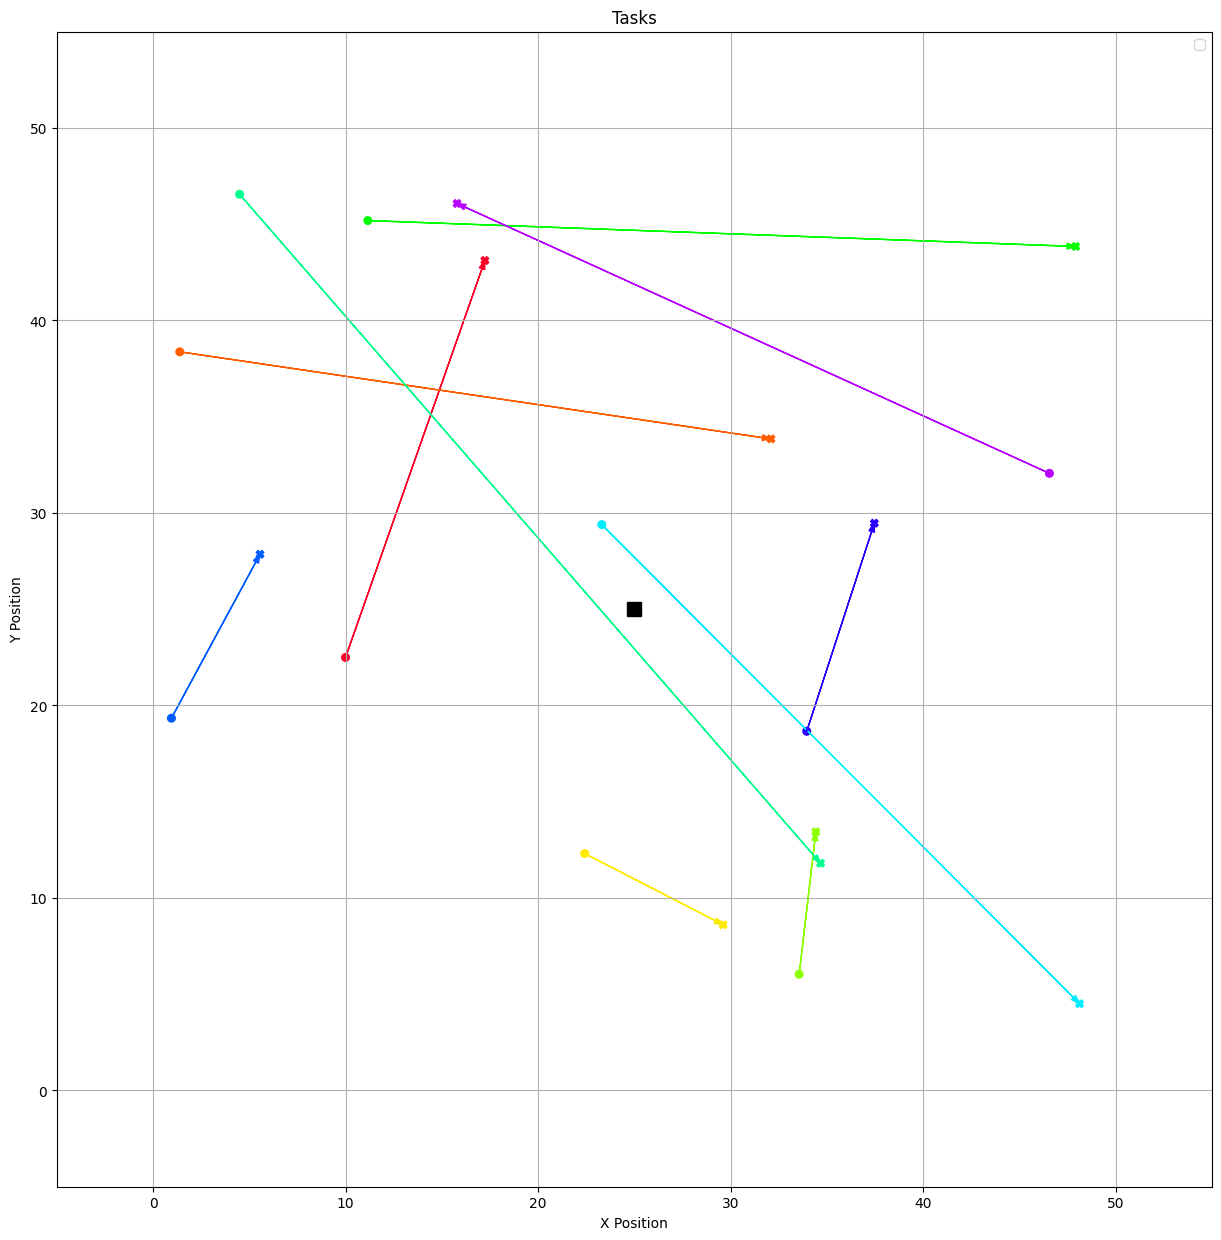

In [16]:
# plot individual tasks
city = City(CITY_HEIGHT_MINUTES, CITY_WIDTH_MINUTES, N_DISTRICTS_X, N_DISTRICTS_Y, N_TASKS, N_SCENARIOS)
visualize_tasks(city)

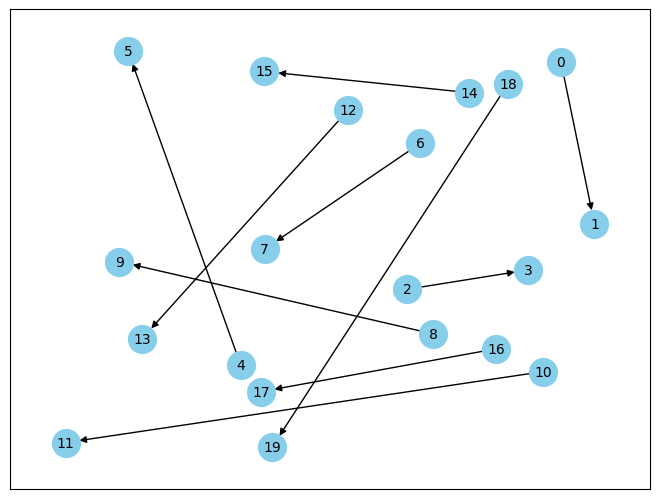

In [34]:
# plot individual tasks in nxGraph
task_start_positions: list[tuple] = city.positions_start
task_end_positions:list[tuple] = city.positions_end
n_tasks = city.n_tasks
start_x, start_y = zip(*task_start_positions)
end_x, end_y = zip(*task_end_positions)

# create new directed graph
G = nx.DiGraph()
for n in range(n_tasks):
    G.add_node(n*2, pos=task_start_positions[n])
    G.add_node(n*2+1, pos=task_end_positions[n])
    G.add_edge(n*2, n*2+1, name=f"task {n}")

# we have to assign node positions mmanually and get the attributes' values
# otherwise nxGraph uses spring_layout by default
pos = nx.get_node_attributes(G,'pos')
nx.draw(G=G, 
        pos=pos,
        with_labels=True, 
        node_size=400, 
        node_color="skyblue", 
        font_size=10, 
        arrows=True)

plt.xticks(range(0, CITY_WIDTH_MINUTES))
plt.yticks(range(0, CITY_HEIGHT_MINUTES))
plt.axis('on')
plt.show()

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111)
# ax.set_axisbelow(True)
# ax.yaxis.grid(color='gray', linestyle='dashed')
# plt.grid(True)

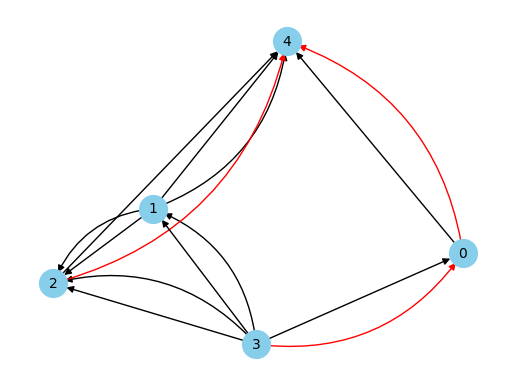

In [56]:
def visualize_paths_nx(G: SimpleDirectedGraph, vsp_path: list[int]):
    """compare SVSP ground truth and solution using nxGraph"""
    nxgraph = nx.DiGraph()
    E = list(G.get_edges())
    for e in E:
        nxgraph.add_edge(e.from_vertex.name, e.to_vertex.name)

    pos = nx.spring_layout(nxgraph)
    node_path = set()
    edge_path = [(E[i].from_vertex.name, E[i].to_vertex.name) 
                 for i, v in enumerate(vsp_path) if v == 1]
    for e in edge_path:
        node_path.add(e[0])
        node_path.add(e[1])

    # Draw nodes and edges not included in path
    nx.draw_networkx_nodes(nxgraph, pos, nodelist=set(nxgraph.nodes)-node_path)
    nx.draw_networkx_edges(nxgraph, pos, edgelist=set(nxgraph.edges)-set(edge_path), connectionstyle='arc3, rad = 0.3')

    # Draw nodes and edges included in path
    nx.draw_networkx_nodes(nxgraph, pos, nodelist=node_path, node_color='r')
    nx.draw_networkx_edges(nxgraph, pos, edgelist=edge_path, edge_color='r', connectionstyle='arc3, rad = 0.3')

    nx.draw(G=nxgraph, 
        pos=pos,
        with_labels=True, 
        node_size=400, 
        node_color="skyblue", 
        font_size=10, 
        arrows=True)

visualize_paths_nx(city.graph, [1,1,0,0,0,0,1])
# visualize_paths_nx(city.graph, [1,1,0,0,0,1,1])
    

In [8]:
import networkx as nx
from pyvis.network import Network

def visualize_path_pyvis(graph: SimpleDirectedGraph, paths: dict[list[Edge]]):
    """
    Creates a graph.html of the visualization
    """
    G = nx.DiGraph()
    V = graph.get_vertices()
    E = graph.get_edges()
    
    for v in V:
        G.add_node(v.name)

    for e in E:
        G.add_edge(e.from_vertex.name, e.to_vertex.name)

    # Plot with pyvis
    net = Network(
        directed = True,
        select_menu = True, # Show part 1 in the plot (optional)
        filter_menu = True, # Show part 2 in the plot (optional)
    )
    net.show_buttons() # Show part 3 in the plot (optional)
    net.from_nx(G) # Create directly from nx graph
    net.show('test.html', notebook=False)

visualize_path_pyvis(city.graph, None)



KeyboardInterrupt



## More graphs plot examples with Networkx
All code snippets below can (and should best) be run separately

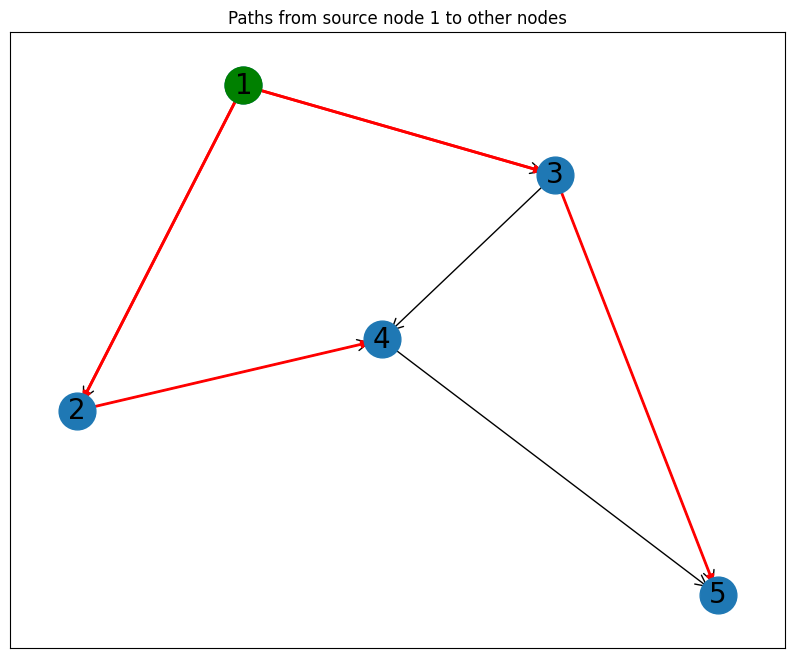

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (3, 5)]
G.add_edges_from(edges)

# Define the source node
source = 1

# Compute the shortest path from the source to all other nodes
paths = {target: nx.shortest_path(G, source, target) for target in G.nodes if target != source}

# Plot the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# Highlight the paths from the source to each target node
for path in paths.values():
    edge_list = [(path[n], path[n+1]) for n in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='r', width=2)

# Highlight the source node
nx.draw_networkx_nodes(G, pos, nodelist=[source], node_color='g', node_size=700)

plt.title(f"Paths from source node {source} to other nodes")
plt.show()

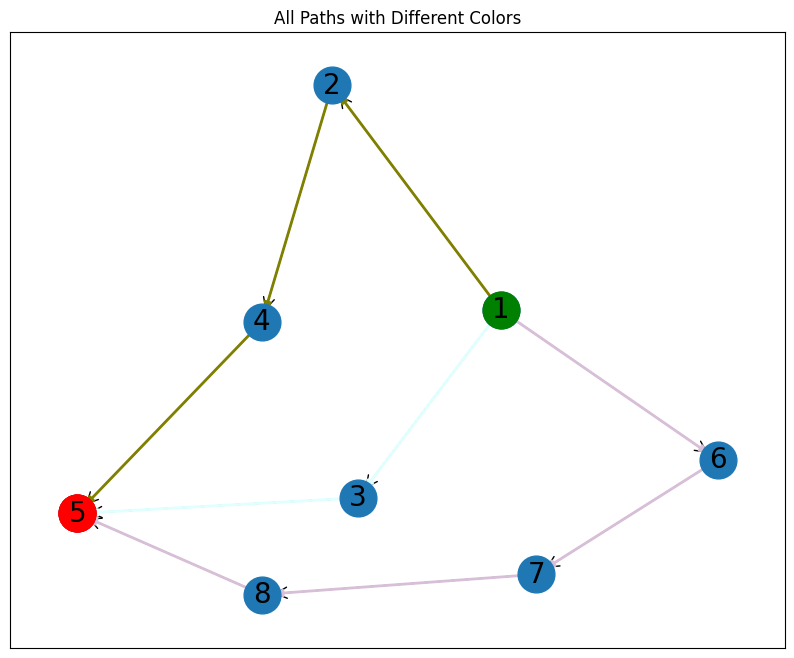

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
edges = [(1, 2), (2, 4), (4, 5), (1, 3), (3, 5), (1, 6), (6, 7), (7, 8), (8, 5)]
G.add_edges_from(edges)

# Define the source node
source = 1

# List of predefined paths (example paths, you can replace these with your actual paths)
paths = [
    [1, 2, 4, 5],
    [1, 3, 5],
    [1, 6, 7, 8, 5]
]

# Generate a unique color for each path
colors = list(mcolors.CSS4_COLORS.values())
random.shuffle(colors)

# Plot the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# Highlight the paths with different colors
for i, path in enumerate(paths):
    edge_list = [(path[n], path[n+1]) for n in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color=colors[i], width=2)

# Highlight the source node
nx.draw_networkx_nodes(G, pos, nodelist=[source], node_color='g', node_size=700)

# Highlight the sink nodes
sink_nodes = [path[-1] for path in paths]
nx.draw_networkx_nodes(G, pos, nodelist=sink_nodes, node_color='r', node_size=700)

plt.title("All Paths with Different Colors")
plt.show()

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Create a directed graph
G = nx.DiGraph()
edges = [(1, 2), (2, 4), (4, 5), 
         (1, 3), (3, 5), 
         (1, 6), (6, 7), (7, 8), (8, 5),
         (1, 9), (9, 10), (10, 11), (11, 12), (12, 5)]
G.add_edges_from(edges)

# sink nodes can be retrieven from paths
source = 1
paths = [
    [1, 2, 4, 5],
    [1, 3, 5],
    [1, 6, 7, 8, 5],
    [1, 9, 10, 11, 12, 5]
]

def dfs_layout(G, start_node):
    pos = {}
    levels = {}

    def dfs(v, level=0):
        if v not in pos:
            pos[v] = (level, len(pos))
            if level in levels:
                levels[level].append(v)
            else:
                levels[level] = [v]
            for neighbor in G[v]:
                dfs(neighbor, level + 1)
    
    dfs(start_node)
    
    # Adjust the y-coordinates to ensure nodes at the same level are aligned
    for level in levels:
        for i, node in enumerate(levels[level]):
            pos[node] = (level, i)
    
    return pos

# Plot the graph
# pos = nx.spring_layout(G)
pos = dfs_layout(G, source)
plt.figure(figsize=(10, 8))


def plot_selected_path(path_index):
    path = paths[path_index]
    
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    # Highlight the selected path
    edge_list = [(path[n], path[n+1]) for n in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='r', width=2)

    # Highlight the source node
    nx.draw_networkx_nodes(G, pos, nodelist=[source], node_color='g', node_size=700)

    # Highlight the sink node
    sink_node = path[-1]
    nx.draw_networkx_nodes(G, pos, nodelist=[sink_node], node_color='y', node_size=700)

    plt.title(f"Selected Path: {path}")
    plt.show()

# Create a dropdown widget for path selection
path_dropdown = Dropdown(options=list(range(len(paths))), description="Path Index")
interact(plot_selected_path, path_index=path_dropdown)

<Figure size 1000x800 with 0 Axes>

interactive(children=(Dropdown(description='Path Index', options=(0, 1, 2, 3), value=0), Output()), _dom_class…

<function __main__.plot_selected_path(path_index)>

In [61]:
import networkx as nx
import bqplot as bq
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np

# create graph
G = nx.DiGraph()
edges = [(1, 2), (2, 4), (4, 5), 
         (1, 3), (3, 5), 
         (1, 6), (6, 7), (7, 8), (8, 5),
         (1, 9), (9, 10), (10, 11), (11, 12), (12, 5)]
G.add_edges_from(edges)

# sink nodes can be retrieven from paths
source = 1
paths = [
    [1, 2, 4, 5],
    [1, 3, 5],
    [1, 6, 7, 8, 5],
    [1, 9, 10, 11, 12, 5]
]

# Define positions based on the 'position' property of nodes
n_nodes = 13
x_pos, y_pos = np.random.randint(low=-10, high=10, size=n_nodes), np.random.randint(low=-10, high=10, size=n_nodes)
positions = {i+1: (pos[0], pos[1]) for i, pos in enumerate(zip(x_pos, y_pos))}

# Identify sink nodes
sink_nodes = set()
for path in paths:
    sink_nodes.add(path[-1])
sink_nodes = list(sink_nodes)

# Convert positions to arrays for bqplot
x = np.array([positions[node][0] for node in G.nodes()])
y = np.array([positions[node][1] for node in G.nodes()])
labels = [str(n) for n in list(G.nodes())]

# Create bqplot scales and axes
x_sc = bq.LinearScale()
y_sc = bq.LinearScale()

ax_x = bq.Axis(scale=x_sc, label='X Axis')
ax_y = bq.Axis(scale=y_sc, orientation='vertical', label='Y Axis')

# Create node scatter plot
node_colors = ['green' if node == source else 'yellow' if node in sink_nodes else 'lightblue' for node in G.nodes()]
node_scatter = bq.Scatter(x=x, y=y, scales={'x': x_sc, 'y': y_sc}, 
                          colors=node_colors, default_size=200, enable_move=False, 
                          labels=labels, display_names=True)

# Create edge lines with arrows
arrows = []
for edge in G.edges():
    x0, y0 = positions[edge[0]]
    x1, y1 = positions[edge[1]]
    line = bq.Lines(x=[x0, x1], y=[y0, y1], scales={'x': x_sc, 'y': y_sc}, 
                    colors=['gray'], stroke_width=2, marker_end='triangle')
    arrows.append(line)

# Create bqplot figure
fig = bq.Figure(marks=[node_scatter] + arrows, axes=[ax_x, ax_y], title="Fixed Nodes Graph with Custom Positions")

# Highlight a selected path
def highlight_path(path_index):
    path = paths[path_index]
    for line in arrows:
        line.colors = ['gray']
    for i in range(len(path) - 1):
        for j, edge in enumerate(G.edges()):
            if edge == (path[i], path[i+1]):
                arrows[j].colors = ['red']

path_dropdown = widgets.Dropdown(options=list(range(len(paths))), description='Path Index')

# Display the list of paths
paths_list = widgets.HTML(
    value="<br>".join([f"Path {i}: {path}" for i, path in enumerate(paths)]),
    placeholder='',
    description='Solution paths:',
    
)

# Create an interactive widget for path selection
interact(highlight_path, path_index=path_dropdown)

# Display the figure and the list of paths
widgets.VBox([fig, paths_list])


interactive(children=(Dropdown(description='Path Index', options=(0, 1, 2, 3), value=0), Output()), _dom_class…